# eda003
売れ筋商品の確認

In [19]:
import os
import sys
from dotenv import load_dotenv
load_dotenv
sys.path.append(os.getenv('UTILS_PATH'))
import datetime
from dateutil.relativedelta import relativedelta
import pandas as pd
import matplotlib.pyplot as plt; plt.style.use("ggplot")
import seaborn as sns
from PIL import Image
from pathlib import Path

In [20]:
INPUT_DIR = os.getenv('INPUT_DIR')
OUTPUT_DIR = os.getenv('OUTPUT_DIR')

In [22]:
import builtins
import types

def imports():
    for name, val in globals().items():
        # module imports
        if isinstance(val, types.ModuleType):
            yield name, val

            # functions / callables
        if hasattr(val, '__call__'):
            yield name, val


def noglobal(f):
    '''
    ref: https://gist.github.com/raven38/4e4c3c7a179283c441f575d6e375510c
    '''
    return types.FunctionType(f.__code__,
                              dict(imports()),
                              f.__name__,
                              f.__defaults__,
                              f.__closure__
                              )

In [23]:
def show_images(article_ids, cols=1, rows=-1):
    if isinstance(article_ids, int) or isinstance(article_ids, str):
        article_ids = [article_ids]
    article_count = len(article_ids)
    if rows < 0: rows = (article_count // cols) + 1
    plt.figure(figsize=(3 + 3.5 * cols, 3 + 5 * rows))
    for i in range(article_count):
        article_id = ("0" + str(article_ids[i]))[-10:]
        plt.subplot(rows, cols, i + 1)
        plt.axis('off')
        plt.title(article_id)
        try:
            image = Image.open(INPUT_DIR + f"images/{article_id[:3]}/{article_id}.jpg")
            plt.imshow(image)
        except:
            pass

In [24]:
articles = pd.read_csv(INPUT_DIR + 'articles.csv', dtype='object')
customers = pd.read_csv(INPUT_DIR + 'customers.csv')
transactions = pd.read_csv(INPUT_DIR + 'transactions_train.csv', dtype={'customer_id':'str'}, parse_dates=['t_dat'])
sample = pd.read_csv(INPUT_DIR + 'sample_submission.csv')

In [25]:
article_list = articles['article_id'].tolist()

In [26]:
@noglobal
def get_customer_frequent(history, n=12, timedelta=None):
    """顧客ごと商品の購入数をカウントし上位の商品を抽出

    Args:
        history (dataframe): 集計対象の実績データ
        n (int): レコメンド対象とする数
        timedelta (dateutil.relativedelta): 指定された場合、実績データの終端からtimedelta分のデータを取得する

    Returns:
        dataframe: 抽出結果
    """
    if timedelta is not None:
        st_date = history['t_dat'].max() - timedelta
        history = history[history['t_dat']>=st_date].copy()
        
    customer_agg = history.groupby(['customer_id', 'article_id'])['t_dat'].count().reset_index()
    customer_agg = customer_agg.rename(columns={'t_dat':'cnt'})
    customer_agg = customer_agg.sort_values(['customer_id', 'cnt'], ascending=False)
    result = customer_agg.groupby('customer_id').head(n)
    return result[['customer_id', 'article_id']]

@noglobal
def get_popular_article(history, n=12, timedelta=None):
    """全体の購入数をカウントし上位の商品を抽出

    Args:
        history (dataframe): 集計対象の実績データ
        n (int): レコメンド対象とする数
        timedelta (dateutil.relativedelta): 指定された場合、実績データの終端からtimedelta分のデータを取得する

    Returns:
        list: 抽出結果
    """
    # 全体の購入数量
    if timedelta is not None:
        st_date = history['t_dat'].max() - timedelta
        history = history[history['t_dat']>=st_date].copy()

    total_agg = history.groupby('article_id')['t_dat'].count().reset_index()
    total_agg = total_agg.rename(columns={'t_dat':'cnt'})
    total_agg = total_agg.sort_values(['cnt'], ascending=False)
    total_agg = total_agg.head(n)
    result = list(total_agg['article_id'].values)
    return result

@noglobal
def get_reccomend(target_customer_id, history):
    """対象のcustomer_idに対するレコメンド結果を返す

    Args:
        target_customer_id (list): 対象のcustomer_id
        history (dataframe): レコメンドに用いる実績データ

    Returns:
        dataframe: レコメンド結果
    """
    n = 12
    result = pd.DataFrame()
    
    for td in [None, relativedelta(weeks=1), relativedelta(months=1), relativedelta(years=1)]:

        customer_freq = get_customer_frequent(history, n, td)
        popular_article = get_popular_article(history, n, td)
        # customerとpopular articleの全組み合わせでdataframe作成
        popular_article = pd.DataFrame(itertools.product(target_customer_id, popular_article), columns=['customer_id', 'article_id'])
        tmp = pd.concat([customer_freq, popular_article])
        result = result.append(tmp)
    result = result.drop_duplicates()
    result = result[result['customer_id'].isin(target_customer_id)].copy()

    return result

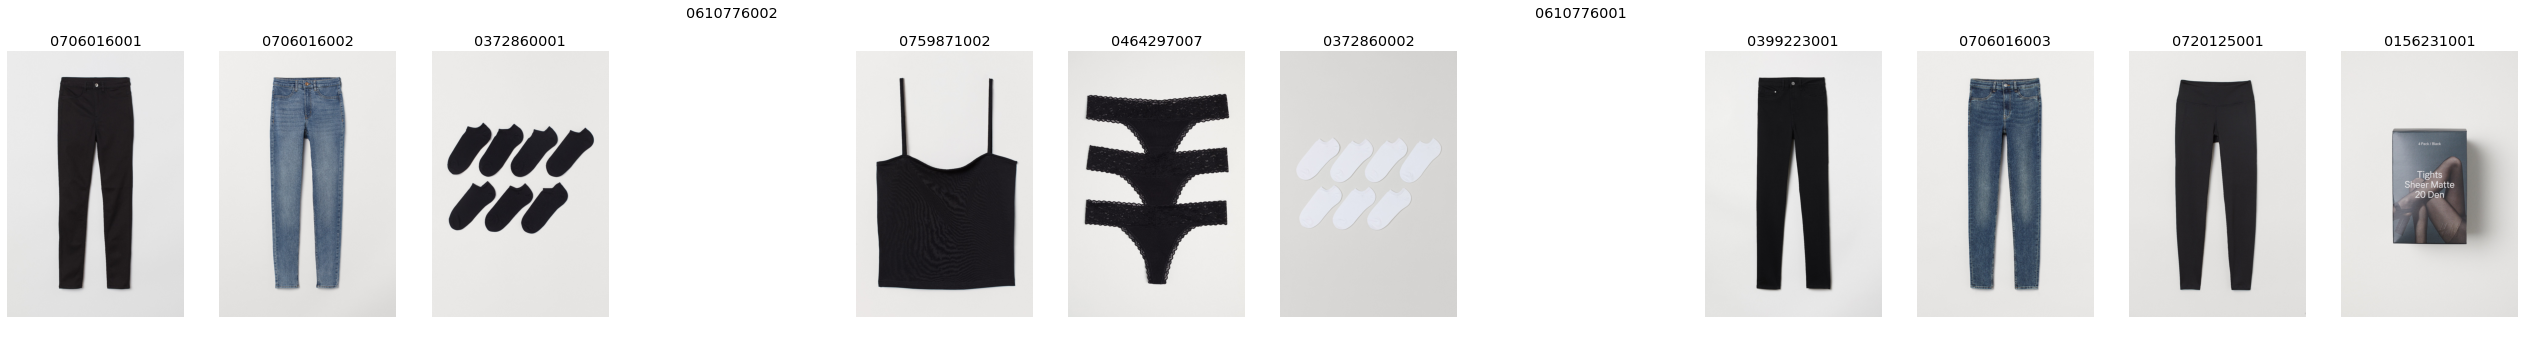

In [30]:
# 全期間・全ユーザの売れ筋商品TOP12
show_images(get_popular_article(transactions, n=12, timedelta=None), cols=12)

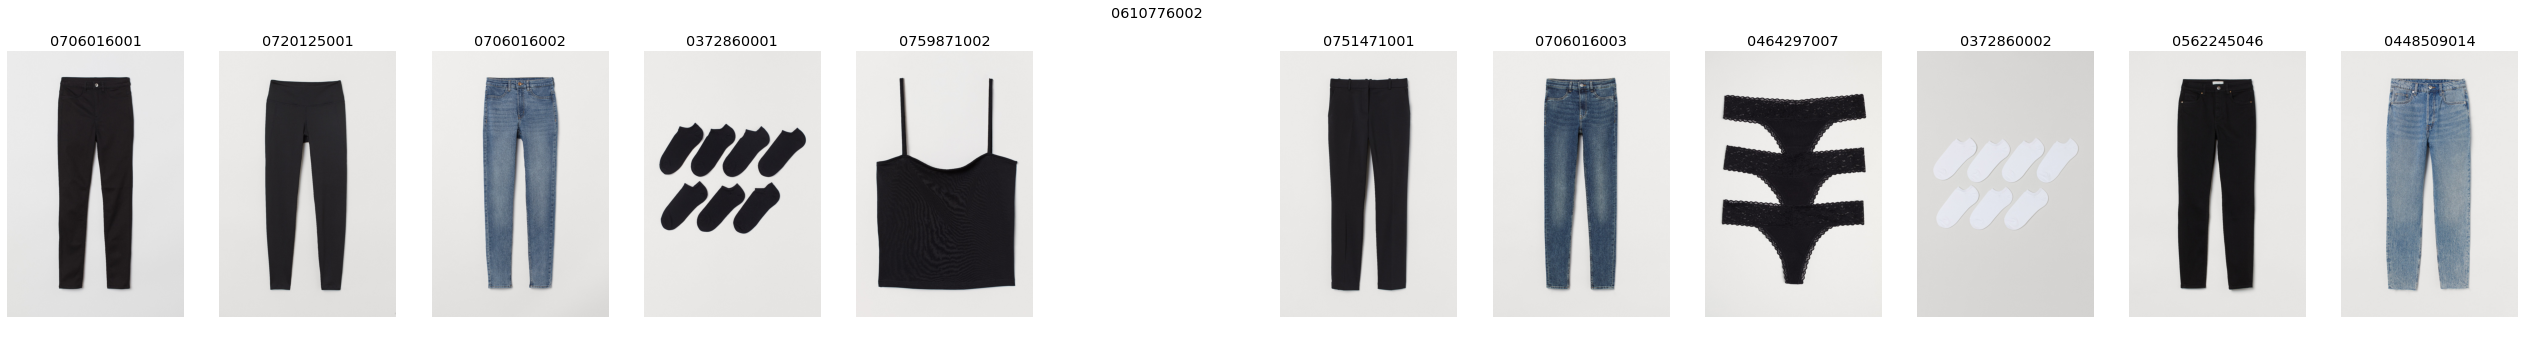

In [34]:
# 直近１年間・全ユーザの売れ筋商品TOP12
show_images(get_popular_article(transactions, n=12, timedelta=relativedelta(years=1)), cols=12)

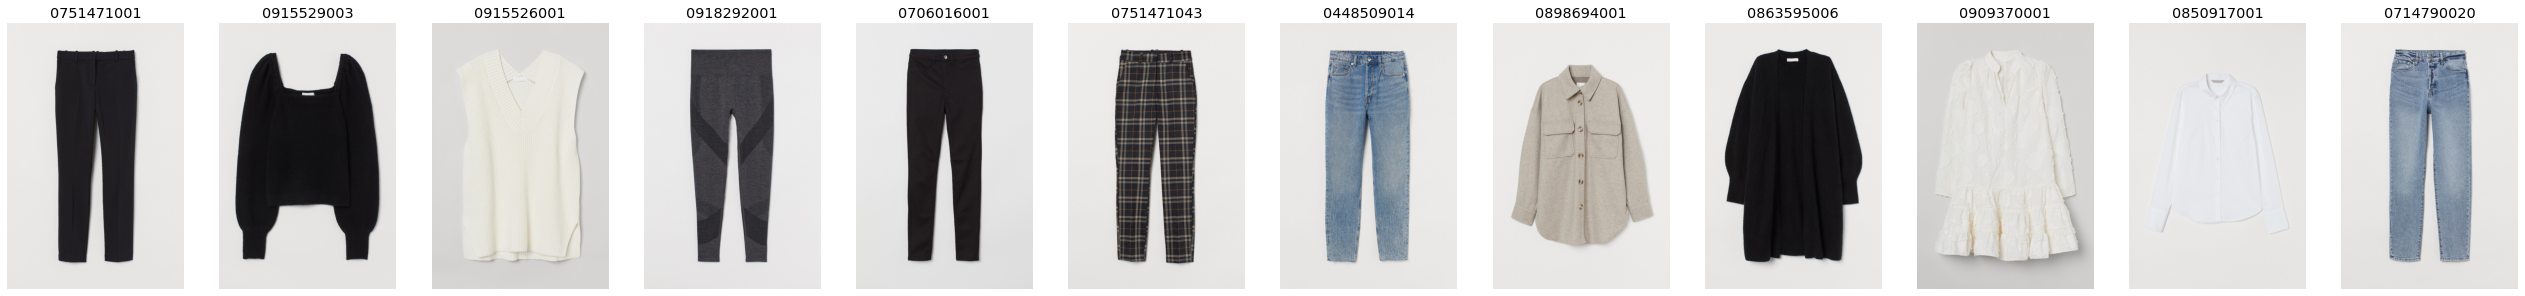

In [35]:
# 直近１か月・全ユーザの売れ筋商品TOP12
show_images(get_popular_article(transactions, n=12, timedelta=relativedelta(months=1)), cols=12)

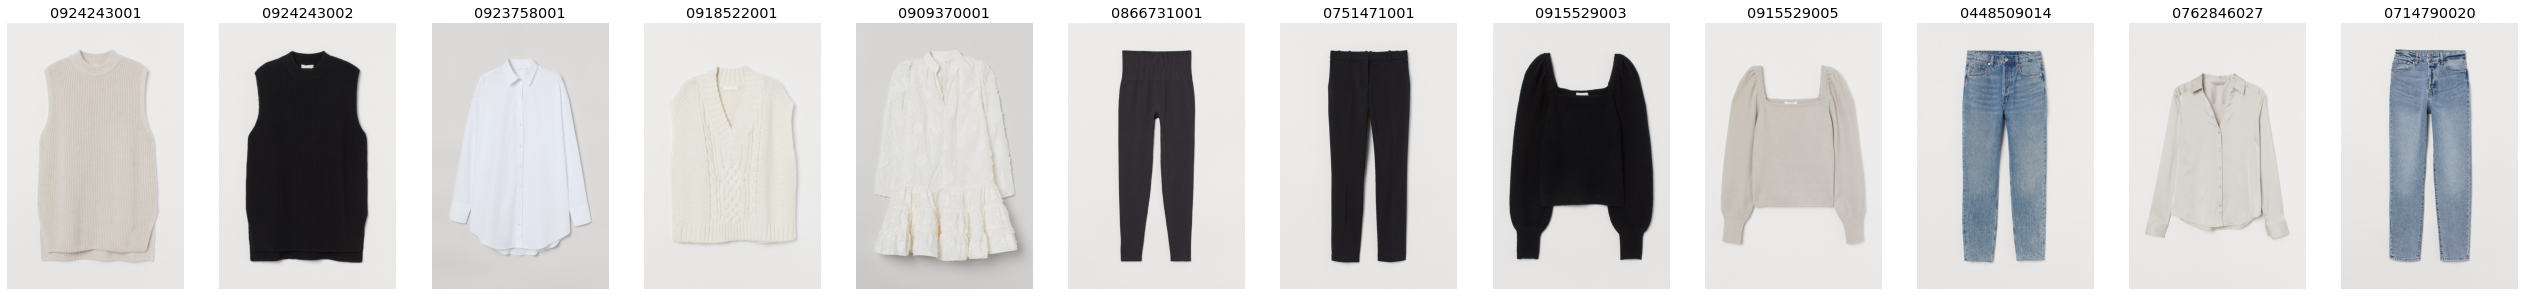

In [36]:
# 直近１週間・全ユーザの売れ筋商品TOP12
show_images(get_popular_article(transactions, n=12, timedelta=relativedelta(weeks=1)), cols=12)

In [37]:
# 顧客ごと
df = get_customer_frequent(transactions, n=12, timedelta=None)

In [40]:
customer_list = customers['customer_id'].tolist()

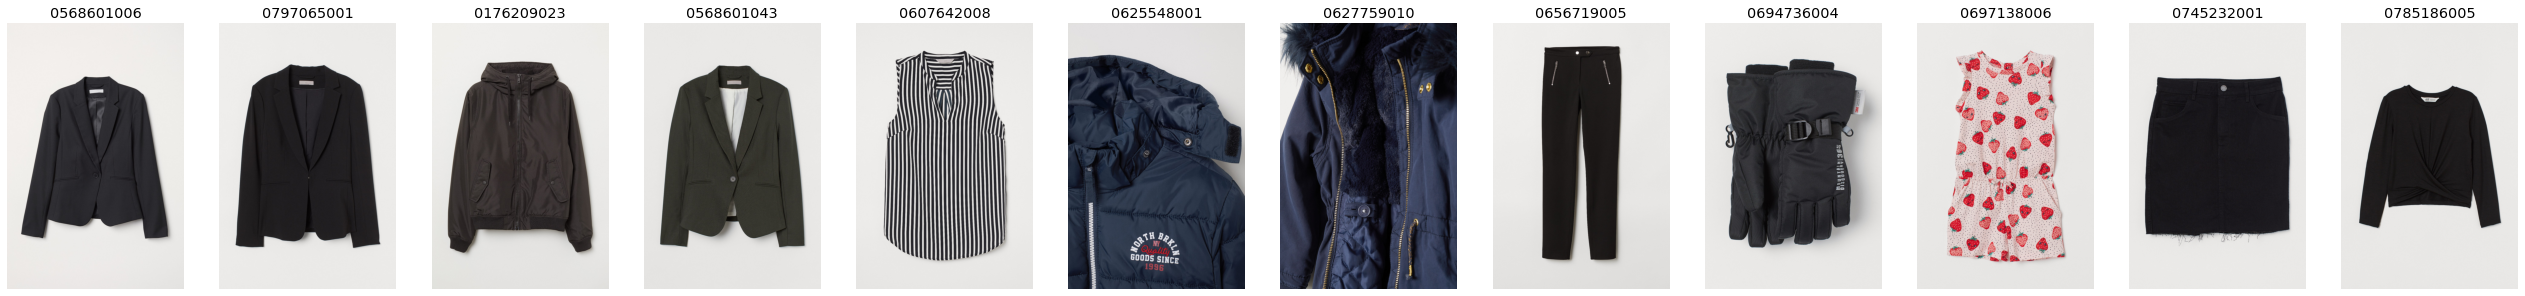

In [43]:
customer = customer_list[0]
show_images(df[df['customer_id']==customer]['article_id'].tolist(), cols=12)

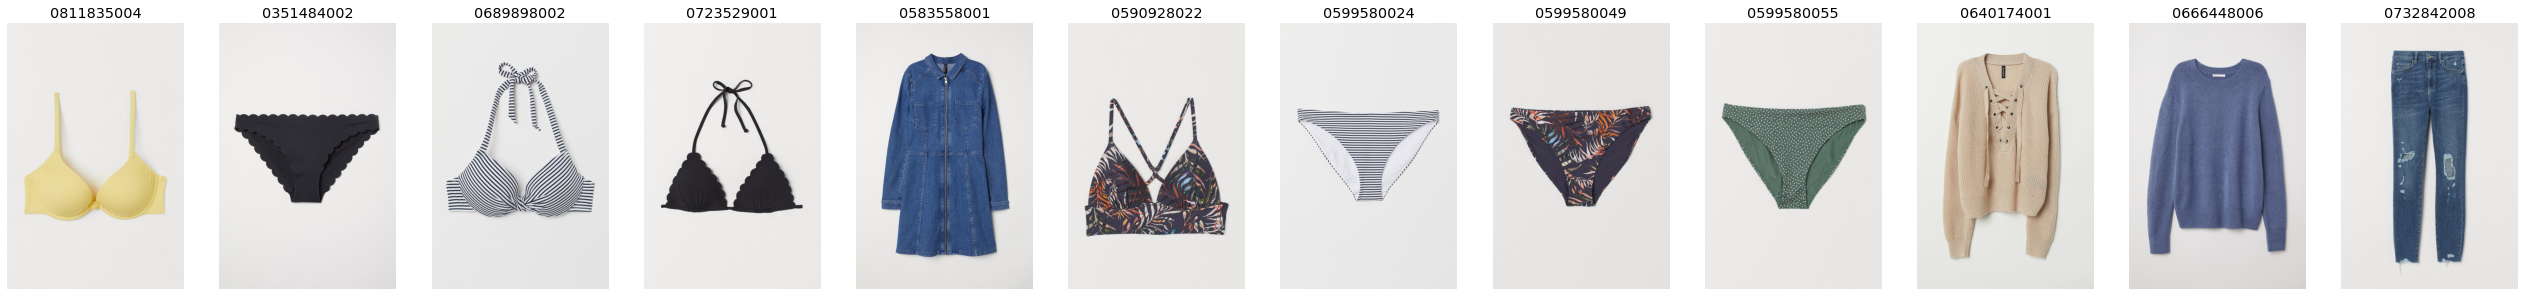

In [44]:
customer = customer_list[1]
show_images(df[df['customer_id']==customer]['article_id'].tolist(), cols=12)

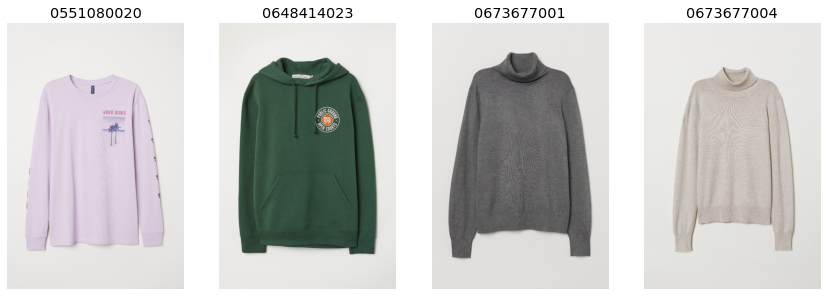

In [52]:
customer = customer_list[9]
show_images(df[df['customer_id']==customer]['article_id'].tolist(), cols=12)

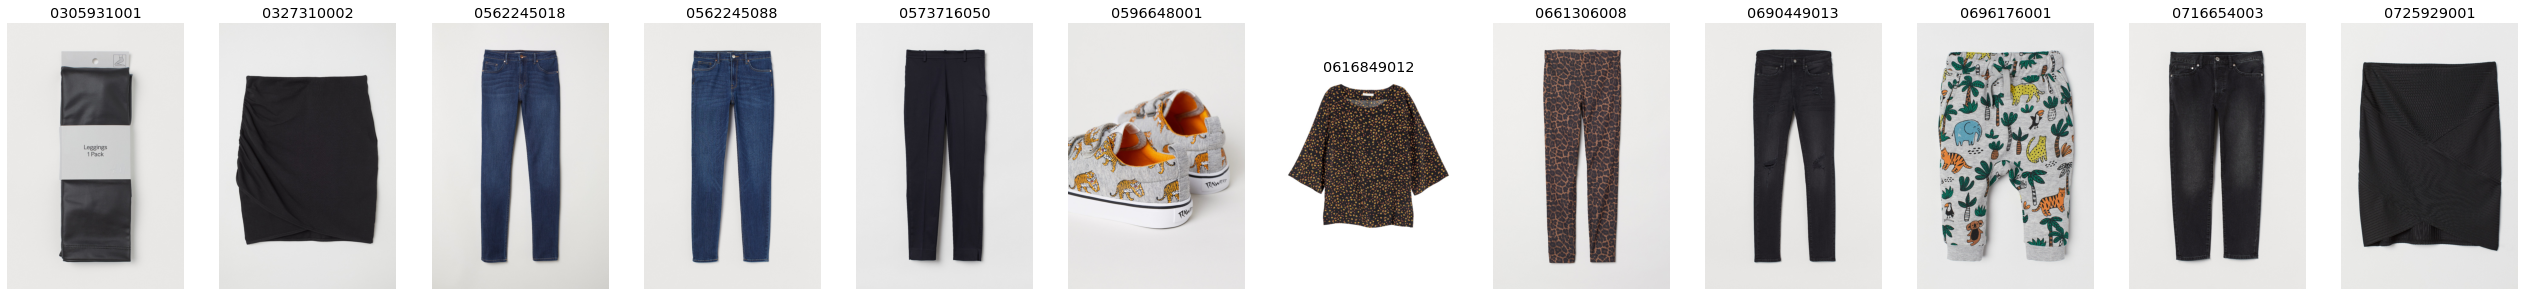

In [68]:
customer = customer_list[25]
show_images(df[df['customer_id']==customer]['article_id'].tolist(), cols=12)